In [11]:
!pip install -q tensorflow matplotlib seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers, Model
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

# ------------------------------------------------------------------
# UTILS
# ------------------------------------------------------------------
def plot_confusion(y_true, y_pred, title="Confusion Matrix", labels=None, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels if labels is not None else np.unique(y_true),
                yticklabels=labels if labels is not None else np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def compute_gradcam(model, image, class_index, last_conv_name):
    grad_model = Model(inputs=model.inputs,
                       outputs=[model.get_layer(last_conv_name).output, model.output])
    with tf.GradientTape() as tape:
        inputs = tf.cast(tf.expand_dims(image, axis=0), tf.float32)
        conv_out, preds = grad_model(inputs)
        loss = preds[:, class_index]
    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_out, pooled_grads), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-9)
    return heatmap.numpy()

def show_gradcam_overlay(gray_or_rgb_img, heatmap, alpha=0.5):
    if heatmap.ndim == 2:
        h = tf.image.resize(heatmap[..., None], gray_or_rgb_img.shape[:2]).numpy().squeeze()
    else:
        h = tf.image.resize(heatmap, gray_or_rgb_img.shape[:2]).numpy().squeeze()
    plt.imshow(gray_or_rgb_img.squeeze(), cmap='gray' if gray_or_rgb_img.shape[-1]==1 else None)
    plt.imshow(h, cmap='jet', alpha=alpha)
    plt.axis('off'); plt.show()


In [4]:
# ------------------------------------------------------------------
# PART A: MNIST
# ------------------------------------------------------------------
print("\n=== MNIST: load & preprocess ===")
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0
X_train = np.expand_dims(X_train, -1)  # (N,28,28,1)
X_test  = np.expand_dims(X_test, -1)
num_classes = 10

# ---------- CNN builder with variable number of conv blocks ----------
def build_mnist_cnn(conv_blocks=2, base_filters=32, last_conv_name="last_conv"):
    inp = layers.Input(shape=(28,28,1))
    x = inp
    filters = base_filters
    for b in range(conv_blocks):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        # downsample every block
        x = layers.MaxPooling2D(2)(x)
        filters = min(filters*2, 256)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same', name=last_conv_name)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inp, out, name=f"mnist_cnn_{conv_blocks}blocks")
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


=== MNIST: load & preprocess ===
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step



--- Training MNIST CNN with 1 conv block(s) ---
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.8408 - loss: 0.5983 - val_accuracy: 0.8527 - val_loss: 0.3760
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9846 - loss: 0.0513 - val_accuracy: 0.9882 - val_loss: 0.0423
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9895 - loss: 0.0336 - val_accuracy: 0.9883 - val_loss: 0.0439
[MNIST CNN 1 blocks] Test accuracy: 0.9883


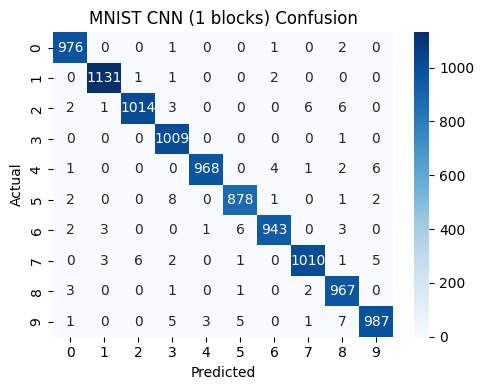


--- Training MNIST CNN with 2 conv block(s) ---
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8832 - loss: 0.3979 - val_accuracy: 0.9462 - val_loss: 0.1955
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9868 - loss: 0.0432 - val_accuracy: 0.9898 - val_loss: 0.0388
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9916 - loss: 0.0258 - val_accuracy: 0.9900 - val_loss: 0.0394
[MNIST CNN 2 blocks] Test accuracy: 0.9912


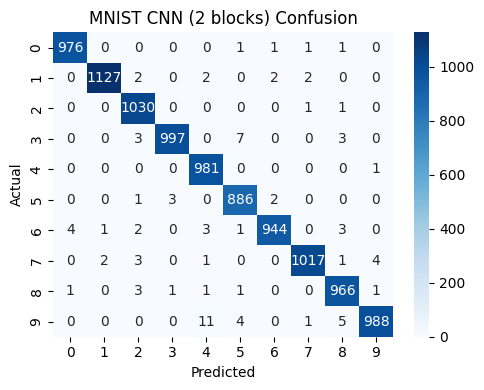


--- Training MNIST CNN with 3 conv block(s) ---
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.8721 - loss: 0.4269 - val_accuracy: 0.9477 - val_loss: 0.1712
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9885 - loss: 0.0385 - val_accuracy: 0.9895 - val_loss: 0.0376
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9914 - loss: 0.0274 - val_accuracy: 0.9910 - val_loss: 0.0430
[MNIST CNN 3 blocks] Test accuracy: 0.9894


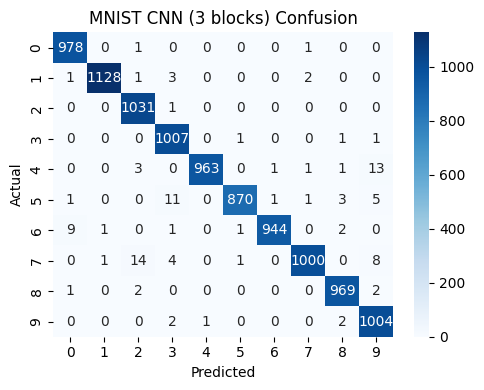


MNIST CNN accuracy by depth:
  Blocks=1: acc=0.9883
  Blocks=2: acc=0.9912
  Blocks=3: acc=0.9894

--- Training MNIST ANN baseline (Flatten + Dense) ---
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7699 - loss: 0.7266 - val_accuracy: 0.9643 - val_loss: 0.1222
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9459 - loss: 0.1849 - val_accuracy: 0.9728 - val_loss: 0.0882
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9609 - loss: 0.1285 - val_accuracy: 0.9778 - val_loss: 0.0780
[MNIST ANN] Test accuracy: 0.9741

--- MNIST Grad-CAM examples (from last CNN trained) ---
MNIST sample #5 | Pred: 1 | True: 1


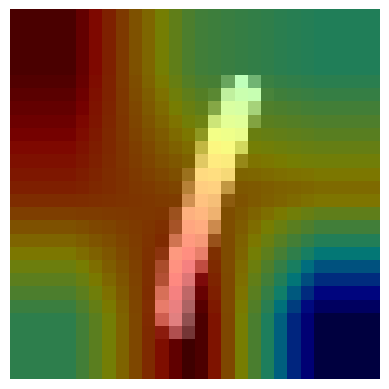

MNIST sample #50 | Pred: 6 | True: 6


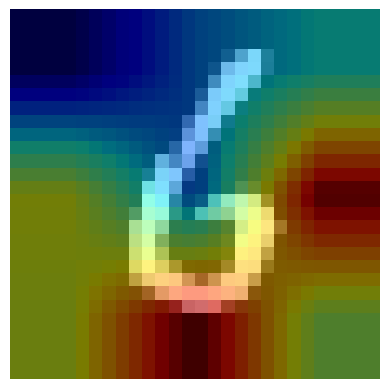

MNIST sample #500 | Pred: 3 | True: 3


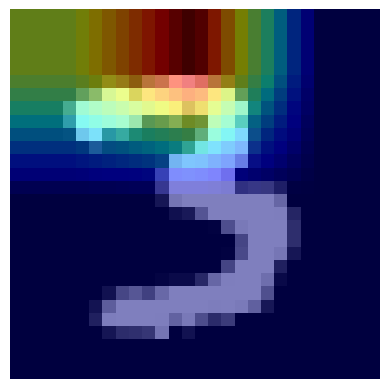

MNIST sample #1500 | Pred: 7 | True: 7


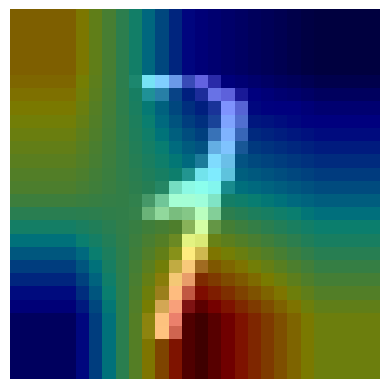

In [5]:
# ---------- Train CNNs with different depths ----------
MNIST_CONV_BLOCKS = [1, 2, 3]  # change to observe accuracy changes
mnist_results = []

for blocks in MNIST_CONV_BLOCKS:
    print(f"\n--- Training MNIST CNN with {blocks} conv block(s) ---")
    cnn = build_mnist_cnn(conv_blocks=blocks, base_filters=32, last_conv_name="mnist_last_conv")
    h = cnn.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=1)
    test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=0)
    print(f"[MNIST CNN {blocks} blocks] Test accuracy: {test_acc:.4f}")
    mnist_results.append((blocks, test_acc))
    # Confusion matrix (optional quick sample)
    y_pred = np.argmax(cnn.predict(X_test, verbose=0), axis=1)
    plot_confusion(y_test, y_pred, title=f"MNIST CNN ({blocks} blocks) Confusion")

print("\nMNIST CNN accuracy by depth:")
for b, acc in mnist_results:
    print(f"  Blocks={b}: acc={acc:.4f}")

# ---------- Optional: ANN baseline on MNIST ----------
print("\n--- Training MNIST ANN baseline (Flatten + Dense) ---")
ann = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=1)
ann_test_acc = ann.evaluate(X_test, y_test, verbose=0)[1]
print(f"[MNIST ANN] Test accuracy: {ann_test_acc:.4f}")

# ---------- Grad-CAM on MNIST (use the last trained CNN) ----------
print("\n--- MNIST Grad-CAM examples (from last CNN trained) ---")
mnist_cnn_for_xai = build_mnist_cnn(conv_blocks=MNIST_CONV_BLOCKS[-1], base_filters=32, last_conv_name="mnist_last_conv")
mnist_cnn_for_xai.fit(X_train, y_train, epochs=2, batch_size=128, validation_split=0.1, verbose=0)
idxs = [5, 50, 500, 1500]
for i in idxs:
    img = X_test[i]
    pred = np.argmax(mnist_cnn_for_xai.predict(img[None, ...], verbose=0), axis=1)[0]
    heat = compute_gradcam(mnist_cnn_for_xai, img, pred, last_conv_name="mnist_last_conv")
    print(f"MNIST sample #{i} | Pred: {pred} | True: {y_test[i]}")
    show_gradcam_overlay(img, heat, alpha=0.5)


=== CIFAR-10: Load & preprocess ===

--- CIFAR-10: Train WITH POOLING ---
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.3411 - loss: 1.7932 - val_accuracy: 0.5534 - val_loss: 1.2499
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5935 - loss: 1.1384 - val_accuracy: 0.6754 - val_loss: 0.9309
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6732 - loss: 0.9248 - val_accuracy: 0.7112 - val_loss: 0.8443
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7231 - loss: 0.7913 - val_accuracy: 0.7356 - val_loss: 0.7758
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7556 - loss: 0.7029 - val_accuracy: 0.7428 - val_loss: 0.7639
[CIFAR-10 WITH POOL] Test accuracy: 0.7240

--- CIFAR-10: Train WITHOUT POOLING (strided conv) ---
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.3264 - loss: 1.8288 - val_accuracy: 0.5342 - val_loss: 1.2948
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - ac

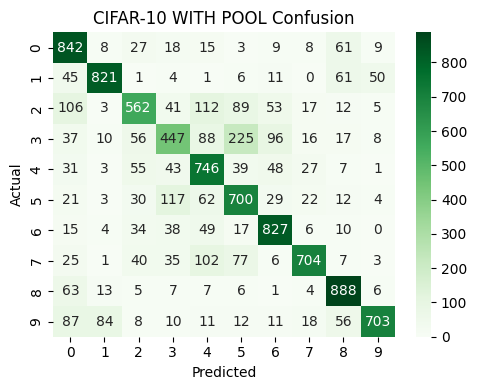

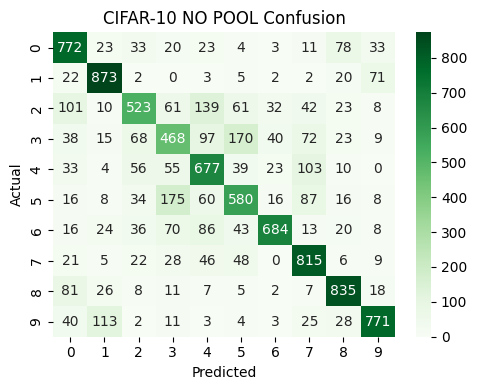


--- CIFAR-10: Grad-CAM Examples (WITH POOL model) ---
CIFAR #10 | Pred=airplane | True=airplane


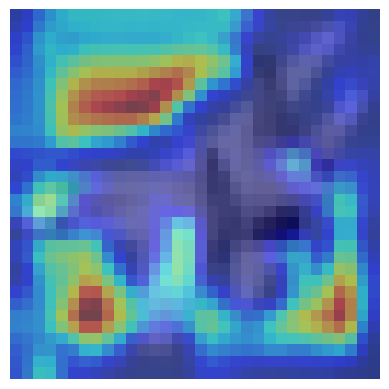

CIFAR #250 | Pred=dog | True=dog


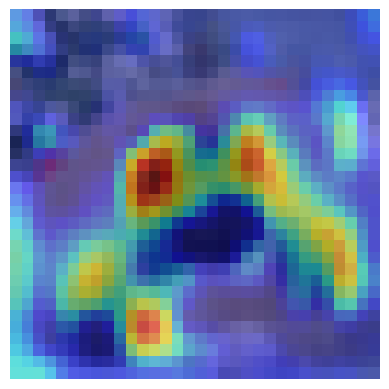

CIFAR #1000 | Pred=dog | True=dog


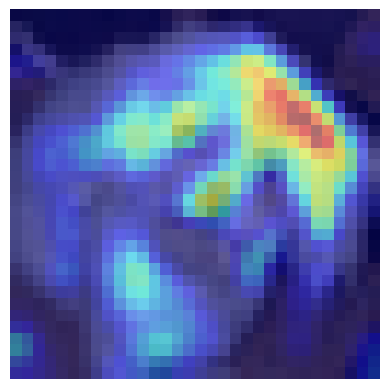

CIFAR #2500 | Pred=deer | True=deer


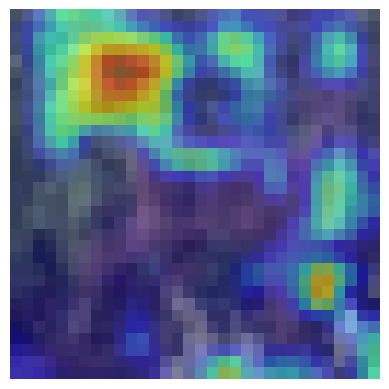


DONE.


In [12]:
# ============================================
# PART B: CIFAR-10 (Portfolio)
# With Pooling vs Without Pooling (strided conv)
# + Grad-CAM
# ============================================
print("\n=== CIFAR-10: Load & preprocess ===")
(Xc_train, yc_train), (Xc_test, yc_test) = cifar10.load_data()
Xc_train = (Xc_train.astype("float32") / 255.0)
Xc_test  = (Xc_test.astype("float32") / 255.0)
yc_train = yc_train.squeeze()
yc_test  = yc_test.squeeze()
cifar_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def build_cifar_with_pool(last_conv_name="cifar_last_conv_pool"):
    inp = layers.Input(shape=(32,32,3))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)  # POOL
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', name=last_conv_name)(x)
    x = layers.MaxPooling2D(2)(x)  # POOL
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(10, activation='softmax')(x)
    m = Model(inp, out, name="cifar_with_pool")
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

def build_cifar_no_pool(last_conv_name="cifar_last_conv_nopool"):
    inp = layers.Input(shape=(32,32,3))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)   # stride instead of pool
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', name=last_conv_name)(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)   # stride instead of pool
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(10, activation='softmax')(x)
    m = Model(inp, out, name="cifar_no_pool")
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

EPOCHS_CIFAR = 5   # set to 10 for better accuracy if you have time

print("\n--- CIFAR-10: Train WITH POOLING ---")
cifar_pool = build_cifar_with_pool()
cifar_pool.fit(Xc_train, yc_train, epochs=EPOCHS_CIFAR, batch_size=128, validation_split=0.1, verbose=1)
pool_acc = cifar_pool.evaluate(Xc_test, yc_test, verbose=0)[1]
print(f"[CIFAR-10 WITH POOL] Test accuracy: {pool_acc:.4f}")

print("\n--- CIFAR-10: Train WITHOUT POOLING (strided conv) ---")
cifar_nopool = build_cifar_no_pool()
cifar_nopool.fit(Xc_train, yc_train, epochs=EPOCHS_CIFAR, batch_size=128, validation_split=0.1, verbose=1)
nopool_acc = cifar_nopool.evaluate(Xc_test, yc_test, verbose=0)[1]
print(f"[CIFAR-10 NO POOL] Test accuracy: {nopool_acc:.4f}")

print("\nCIFAR-10 accuracy comparison:")
print(f"  With Pooling : {pool_acc:.4f}")
print(f"  No Pooling   : {nopool_acc:.4f}")

# Confusion matrices (optional)
for title, model in [("CIFAR-10 WITH POOL", cifar_pool), ("CIFAR-10 NO POOL", cifar_nopool)]:
    preds = np.argmax(model.predict(Xc_test, verbose=0), axis=1)
    plot_confusion(yc_test, preds, title=f"{title} Confusion", labels=range(10), cmap='Greens' if 'POOL' in title else 'Oranges')


# CIFAR-10 Grad-CAM (use the with-pooling model)
print("\n--- CIFAR-10: Grad-CAM Examples (WITH POOL model) ---")
example_idxs = [10, 250, 1000, 2500]
for i in example_idxs:
    img = Xc_test[i]
    pred = np.argmax(cifar_pool.predict(img[None, ...], verbose=0), axis=1)[0]
    heat = compute_gradcam(cifar_pool, img, pred, last_conv_name="cifar_last_conv_pool")
    print(f"CIFAR #{i} | Pred={cifar_labels[pred]} | True={cifar_labels[yc_test[i]]}")
    show_gradcam_overlay(img, heat, alpha=0.5)

print("\nDONE.")